In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.compose import make_column_selector as selector
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn import tree, metrics
from IPython.display import Image  
import pydotplus

from xgboost import XGBClassifier, cv, plot_importance
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, roc_auc_score, f1_score, precision_recall_curve, accuracy_score, confusion_matrix, balanced_accuracy_score
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline


from sklearn.metrics import fbeta_score, make_scorer

import itertools

import warnings
warnings.filterwarnings('ignore')

from imblearn.under_sampling import RandomUnderSampler

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.compose import ColumnTransformer

import datetime

import pickle


In [4]:
SavePath = "C:\\Users\\somfl\\Documents\\Data Science Career Track\\LendingClub\\LendingClubClean.csv"
df = pd.read_csv(SavePath, sep=',', index_col=0)

In [5]:
df.head(4)

,revol_util,dti,chargeoff_within_12_mths,collections_12_mths_ex_med,inq_last_6mths,open_acc,mort_acc,annual_inc,sub_grade,loan_status,...,term,revol_bal,emp_length,home_ownership,num_rev_accts,pub_rec_bankruptcies,tax_liens,loan_amnt,Credit Length (year),fico_score
0,29.7,5.91,0.0,0.0,1.0,7.0,1.0,55000.0,C4,Fully Paid,...,36 months,2765.0,10 years up,MORTGAGE,9.0,0.0,0.0,3600.0,12.334271,697.064619
1,19.2,16.06,0.0,0.0,4.0,22.0,4.0,65000.0,C1,Fully Paid,...,36 months,21470.0,10 years up,MORTGAGE,27.0,0.0,0.0,24700.0,16.000329,697.064619
3,64.5,25.37,0.0,0.0,3.0,12.0,6.0,104433.0,F1,Fully Paid,...,60 months,21929.0,3 years,MORTGAGE,19.0,0.0,0.0,10400.0,17.500702,697.064619
4,68.4,10.20,0.0,0.0,0.0,5.0,0.0,34000.0,C3,Fully Paid,...,36 months,8822.0,4 years,RENT,4.0,0.0,0.0,11950.0,28.167587,697.064619


In [6]:
df.columns

Index(['revol_util', 'dti', 'chargeoff_within_12_mths',
       'collections_12_mths_ex_med', 'inq_last_6mths', 'open_acc', 'mort_acc',
       'annual_inc', 'sub_grade', 'loan_status', 'installment', 'int_rate',
       'term', 'revol_bal', 'emp_length', 'home_ownership', 'num_rev_accts',
       'pub_rec_bankruptcies', 'tax_liens', 'loan_amnt',
       'Credit Length (year)', 'fico_score'],
      dtype='object')

In [44]:
categorical_columns = ['sub_grade', 'term', 'emp_length', 'home_ownership']
numerical_columns = ['revol_util', 'dti', 'chargeoff_within_12_mths', 'collections_12_mths_ex_med', 'inq_last_6mths', 
                     'open_acc', 'mort_acc', 'annual_inc', 'installment', 'int_rate', 'revol_bal', 'num_rev_accts',
                     'pub_rec_bankruptcies', 'tax_liens', 'loan_amnt', 'Credit Length (year)', 'fico_score']

y = df['loan_status']
X = df[numerical_columns + categorical_columns]

X_cols = X.columns
y_col = ['status']

# Undersample
Xn = X.to_numpy()
yn = y.to_numpy()
random_state=42
RU = RandomUnderSampler()
X_res, y_res = RU.fit_resample(Xn,yn)

X_res = pd.DataFrame(X_res, columns = X_cols)
y_res = pd.DataFrame(y_res, columns = y_col)

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, stratify=y_res, test_size=0.25, random_state=42)

categorical_pipe = Pipeline(steps=[('encoder', OneHotEncoder(drop='if_binary'))])
numerical_pipe = Pipeline(steps=[('scaler', MinMaxScaler())])

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_pipe, categorical_columns),
        ("num", numerical_pipe, numerical_columns),
    ]
)


In [28]:
X.shape

(1206759, 21)

In [45]:
lr = Pipeline(
    [
        ("preprocess", preprocessing),
        ("classifier", LogisticRegression(random_state=42))
    ]
)

In [46]:
cv_results = cross_validate(lr, X_train, y_train, scoring = 'balanced_accuracy', cv=5)
cv_scores = cv_results['test_score']
cv_scores

array([0.65193061, 0.65431862, 0.65081254, 0.65166987, 0.65352527])

In [47]:
# Define a set of parameters for grid search
grid_params = {'classifier__penalty': ['l1','l2'],
               'classifier__C': [0.1,100]          
}

# Perform grid search
grid_cv = GridSearchCV(lr, param_grid=grid_params, cv=5, scoring = 'balanced_accuracy', n_jobs=-1)
grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder(drop='if_binary'))]),
                                                                         ['sub_grade',
                                                                          'term',
                                                                          'emp_length',
                                                                          'home_ownership']),
                                                                        ('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                         

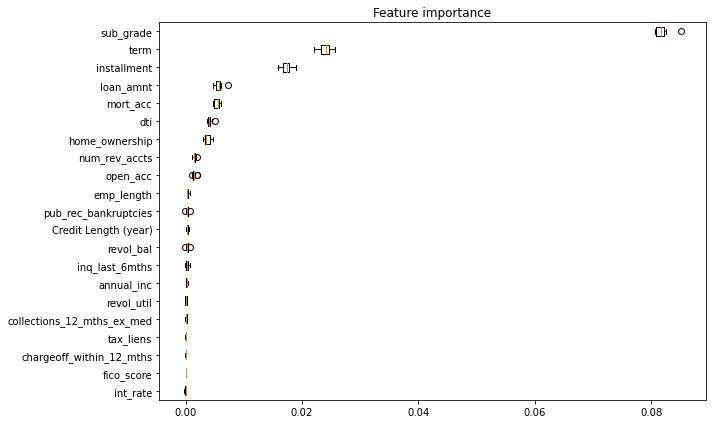

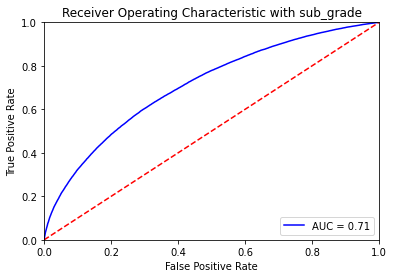

In [48]:
from sklearn.inspection import permutation_importance
result = permutation_importance(
    grid_cv.best_estimator_, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(10,6))
ax.boxplot(
    result.importances[sorted_idx].T, vert=False, labels=X_test.columns[sorted_idx]
)
ax.set_title("Feature importance")
fig.tight_layout()
plt.show()


y_pred = grid_cv.best_estimator_.predict(X_test)
y_prob = grid_cv.best_estimator_.predict_proba(X_test)
probs = y_prob[:,1]
FalsePositiveRate, TruePositiveRate, threshold = metrics.roc_curve(y_test, probs, pos_label='Fully Paid')
roc_auc = metrics.auc(FalsePositiveRate, TruePositiveRate)

plt.title('Receiver Operating Characteristic with sub_grade')
plt.plot(FalsePositiveRate, TruePositiveRate, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

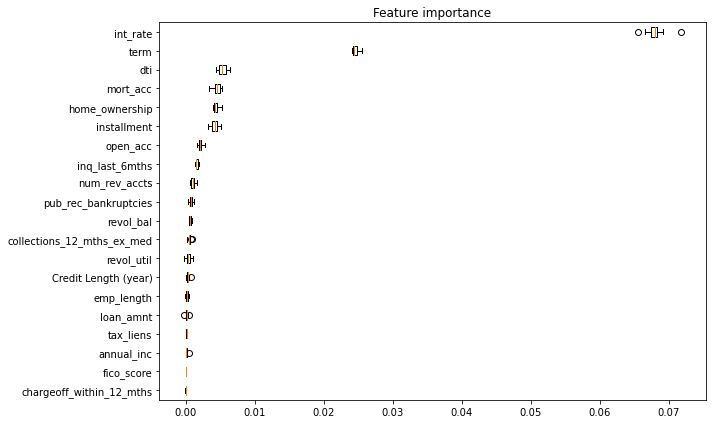

In [35]:
categorical_columns = ['term', 'emp_length', 'home_ownership']
numerical_columns = ['revol_util', 'dti', 'chargeoff_within_12_mths', 'collections_12_mths_ex_med', 'inq_last_6mths', 
                     'open_acc', 'mort_acc', 'annual_inc', 'installment', 'int_rate', 'revol_bal', 'num_rev_accts',
                     'pub_rec_bankruptcies', 'tax_liens', 'loan_amnt', 'Credit Length (year)', 'fico_score']

y = df['loan_status']
X = df[numerical_columns + categorical_columns]

X_cols = X.columns
y_col = ['status']

# Undersample
Xn = X.to_numpy()
yn = y.to_numpy()
random_state=42
RU = RandomUnderSampler()
X_res, y_res = RU.fit_resample(Xn,yn)

X_res = pd.DataFrame(X_res, columns = X_cols)
y_res = pd.DataFrame(y_res, columns = y_col)

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, stratify=y_res, test_size=0.25, random_state=42)

categorical_pipe = Pipeline(steps=[('encoder', OneHotEncoder(drop='if_binary'))])
numerical_pipe = Pipeline(steps=[('scaler', MinMaxScaler())])

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_pipe, categorical_columns),
        ("num", numerical_pipe, numerical_columns),
    ]
)

lr = Pipeline(
    [
        ("preprocess", preprocessing),
        ("classifier", LogisticRegression(random_state=42))
    ]
)

grid_params = {'classifier__penalty': ['l1','l2'],
               'classifier__C': [0.1,100]          
}

# Perform grid search
grid_cv = GridSearchCV(lr, param_grid=grid_params, cv=5, scoring = 'balanced_accuracy', n_jobs=-1)
grid_cv.fit(X_train, y_train)

result = permutation_importance(
    grid_cv.best_estimator_, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(10,6))
ax.boxplot(
    result.importances[sorted_idx].T, vert=False, labels=X_test.columns[sorted_idx]
)
ax.set_title("Feature importance")
fig.tight_layout()
plt.show()

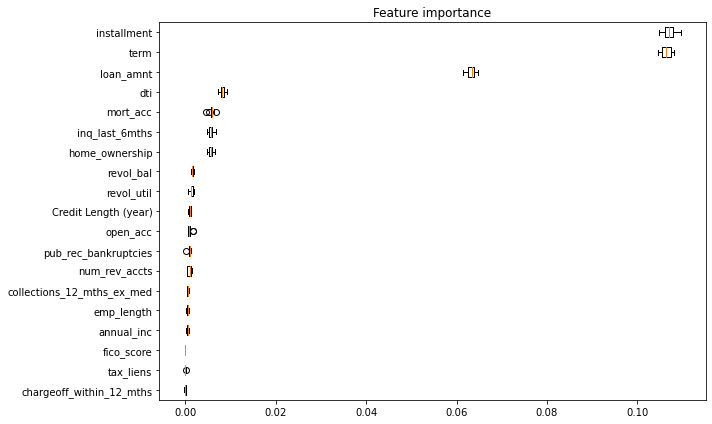

In [36]:
categorical_columns = ['term', 'emp_length', 'home_ownership']
numerical_columns = ['revol_util', 'dti', 'chargeoff_within_12_mths', 'collections_12_mths_ex_med', 'inq_last_6mths', 
                     'open_acc', 'mort_acc', 'annual_inc', 'installment', 'revol_bal', 'num_rev_accts',
                     'pub_rec_bankruptcies', 'tax_liens', 'loan_amnt', 'Credit Length (year)', 'fico_score']

y = df['loan_status']
X = df[numerical_columns + categorical_columns]

X_cols = X.columns
y_col = ['status']

# Undersample
Xn = X.to_numpy()
yn = y.to_numpy()
random_state=42
RU = RandomUnderSampler()
X_res, y_res = RU.fit_resample(Xn,yn)

X_res = pd.DataFrame(X_res, columns = X_cols)
y_res = pd.DataFrame(y_res, columns = y_col)

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, stratify=y_res, test_size=0.25, random_state=42)

categorical_pipe = Pipeline(steps=[('encoder', OneHotEncoder(drop='if_binary'))])
numerical_pipe = Pipeline(steps=[('scaler', MinMaxScaler())])

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_pipe, categorical_columns),
        ("num", numerical_pipe, numerical_columns),
    ]
)

lr = Pipeline(
    [
        ("preprocess", preprocessing),
        ("classifier", LogisticRegression(random_state=42))
    ]
)

grid_params = {'classifier__penalty': ['l1','l2'],
               'classifier__C': [0.1,100]          
}

# Perform grid search
grid_cv = GridSearchCV(lr, param_grid=grid_params, cv=5, scoring = 'balanced_accuracy', n_jobs=-1)
grid_cv.fit(X_train, y_train)

result = permutation_importance(
    grid_cv.best_estimator_, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(10,6))
ax.boxplot(
    result.importances[sorted_idx].T, vert=False, labels=X_test.columns[sorted_idx]
)
ax.set_title("Feature importance")
fig.tight_layout()
plt.show()

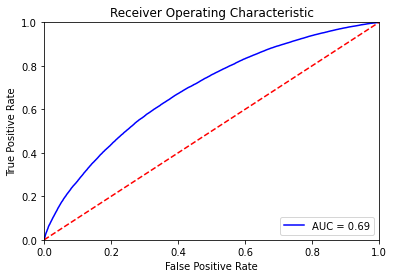

In [43]:
y_pred = grid_cv.best_estimator_.predict(X_test)
y_prob = grid_cv.best_estimator_.predict_proba(X_test)
probs = y_prob[:,1]
FalsePositiveRate, TruePositiveRate, threshold = metrics.roc_curve(y_test, probs, pos_label='Fully Paid')
roc_auc = metrics.auc(FalsePositiveRate, TruePositiveRate)

plt.title('Receiver Operating Characteristic')
plt.plot(FalsePositiveRate, TruePositiveRate, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
y = df['loan_status']
X = df.drop(columns=['loan_status'])

# Choose the categorical columns
col_num =X.shape[1]
categorical_columns_selector = selector(dtype_include=object)
categorical_columns = categorical_columns_selector(X)

# One Hot encode

enc = OneHotEncoder(drop='if_binary')
enc_df = pd.DataFrame(enc.fit_transform(X[categorical_columns]).toarray())
feature_names = enc.get_feature_names(input_features=categorical_columns)
enc_df.columns = feature_names
X.drop(columns=categorical_columns, inplace=True)
# merge with main df bridge_df on key values
X =X.join(enc_df)
#X.set_index('id', inplace=True)
print('The new X has the columns added by One Hot Encoder, which has increased the number of columns from {} to {}'.format(col_num, X.shape[1]))

Xcol_names = X.columns
ycol_name =['Status']

# Undersample
Xn = X.to_numpy()
yn = y.to_numpy()
random_state=42
RU = RandomUnderSampler()
X_res, y_res = RU.fit_resample(Xn,yn)

# Split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=47)

# Change back to panads dataframe
X_train = pd.DataFrame(X_train, columns=Xcol_names)
X_test = pd.DataFrame(X_test, columns=Xcol_names)
y_train = pd.DataFrame(y_train, columns=ycol_name)
y_test = pd.DataFrame(y_test, columns=ycol_name)
